In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
from IPython.display import display
import ast
import copy
import seaborn as sns
import matplotlib.pyplot as plt

#Data Processing Imports
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Model Evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import GridSearchCV

#Models
from sklearn import linear_model
from sklearn import ensemble
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn import linear_model
from catboost import CatBoostRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

## Data Preparation for Model

In [2]:
#read bacteria data

df = pd.read_csv('../data/bacteria_genes.csv', index_col='Unnamed: 0')
df['DB1 genes'] = df['DB1 genes'].apply(lambda x: ast.literal_eval(x))
df.head(3)

,bacteria,disease,levels,taxon id,DB1 genes,DB2 genes,gene subset DB1,gene subset DB2,DB1 length,DB1 subset length,pred
11,Bacteria;Actinobacteria;Actinobacteria;Actinom...,IBS,7,['131109'],"[coaBC, asd, pfp, rlmN, aroB, aroK, nnrD, hflB...","['EII10_10230', 'EII10_08040', 'EII10_07815', ...","{'1': {'dapB', 'uvrB', 'rpmE2', 'nrdH', 'lexA'...",{},1105,778,3
12,Bacteria;Actinobacteria;Actinobacteria;Actinom...,IBS,7,['100469'],"[rlmN, rdgB, prs, asd, aroB, aroK, coaBC, dnaJ...","['EII11_07010', 'EII11_06570', 'EII11_09450', ...","{'0': {'dapB', 'uvrB', 'rpmE2', 'nrdH', 'lexA'...",{},498,780,3
13,Bacteria;Actinobacteria;Actinobacteria;Actinom...,IBS,7,"['888050', '181487']","[coaBC, asd, ilvD, ftsH2, ftsH, rdgB, rlmN, pr...","['HMPREF9004_1386', 'HMPREF9004_0772', 'HMPREF...","{'0': {'dapB', 'hisI', 'hisN', 'uvrB', 'nrdH',...",{},878,781,3


In [3]:
#filter bacteria and its genes of IBS

ibs = df[df['disease'] == 'IBS'][['bacteria', 'DB1 genes']]
ibs.head()

,bacteria,DB1 genes
11,Bacteria;Actinobacteria;Actinobacteria;Actinom...,"[coaBC, asd, pfp, rlmN, aroB, aroK, nnrD, hflB..."
12,Bacteria;Actinobacteria;Actinobacteria;Actinom...,"[rlmN, rdgB, prs, asd, aroB, aroK, coaBC, dnaJ..."
13,Bacteria;Actinobacteria;Actinobacteria;Actinom...,"[coaBC, asd, ilvD, ftsH2, ftsH, rdgB, rlmN, pr..."
14,Bacteria;Actinobacteria;Actinobacteria;Actinom...,[]
15,Bacteria;Actinobacteria;Actinobacteria;Actinom...,"[rdgB, asd, aroB, aroK, ddl, gyrB, alaS, map, ..."


In [4]:
#subset of human genes of interest (taken from hackathon)

humanGenes = ['ABCB1','ABCG2','ABCC1','ABCC2','ABCC3','ABCC4','SLC10A2','SLC15A1','SLC16A1','SLC22A1',
              'SLC22A2','SLC22A3','SLC22A4','SLC22A5','SLC22A6','SLC22A7','SLC22A8','SLC28A2',
              'SLC29A1','SLC29A2','SLC51A','SLC51B','SLCO2B1','CYP1A2','CYP2A6','CYP2D6','CYP2E1',
              'CYP3A4','CYP3A5','SULT1A1','SULT1A3']

In [5]:
#IBD meta data: adding diagnosis column with 1 or 0 for IBS and no IBS respectively

ibs_metadata = pd.read_excel("../Priya_et_al_Supplementary_Tables/Supplementary Table S1.xlsx",
                             engine='openpyxl',sheet_name='IBS_metadata')
ibs_metadata.drop(columns=['Sample_ID', 'Timepoint'], inplace=True)
ibs_metadata.drop_duplicates(inplace=True)
ibs_metadata.set_index('Subject_ID', inplace=True)
ibs_metadata['Diagnosis'] = ibs_metadata['Cohort'].map(lambda cohort: 1 if cohort == 'Healthy' else 0)
ibs_metadata.head(3)

,Cohort,Gender,Diagnosis
Subject_ID,,,
10007541,Healthy,F,1
10007542,IBS-C,F,0
10007544,IBS-D,M,0


In [6]:
#pull bacteria abundance for each human sample

ibs_bacteria_abundance = pd.read_excel("../Priya_et_al_Supplementary_Tables/Supplementary Tables S12-S17.xlsx",
                             engine='openpyxl',sheet_name='S17',index_col=0)
ibs_bacteria_abundance.head(3)

,10007541,10007544,10007547,10007548,10007549,10007557,10007559,10007561,10007562,10007563,...,10007589,10007599,10007600,10007603,10007605,10007613,10007615,10007616,10007572,10007611
Bacteria;Firmicutes;Clostridia;Clostridiales;Ruminococcaceae;Faecalibacterium,84.0,240.0,121.0,2869.5,136.5,69.5,1226.0,73.5,1202.0,988.5,...,628,1135,1001,1175,267,458,27,21,260,959
Bacteria;Firmicutes;Clostridia;Clostridiales;Lachnospiraceae;Blautia,6700.5,4054.5,1247.0,1466.0,2601.5,10772.5,2683.0,2125.5,1855.0,3039.0,...,1354,3062,3790,2443,1886,498,116,4275,2779,1711
Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Prevotellaceae;Prevotella;Prevotella copri,0.0,1599.5,2527.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#human gene expression for each sample

ibs_gene_expression = pd.read_excel("../Priya_et_al_Supplementary_Tables/Supplementary Tables S12-S17.xlsx",
                             engine='openpyxl',sheet_name='S16',index_col=0)
ibs_gene_expression.head(3)

,10007541,10007544,10007547,10007548,10007549,10007557,10007559,10007561,10007562,10007563,...,10007589,10007599,10007600,10007603,10007605,10007613,10007615,10007616,10007572,10007611
MT-CO1,1233052.5,1970083.5,1707092.5,1459311.5,2650858.5,1998441.0,1599566.5,1504184.5,3439689.5,2923490.0,...,2414712,2416438,2880032,1959746,1742470,2556791,3206576,3767032,1963886,3365699
MT-ND4,785415.5,1622945.0,1556023.5,1091569.5,1796827.5,1544957.0,1158247.5,1024348.5,2958771.0,2035010.0,...,1650028,1763181,2357469,1489866,1158342,1815359,2319984,2416877,1558537,2567253
MT-CO3,559446.5,932078.5,941992.5,707785.0,1233331.0,856817.0,701177.5,677470.5,1523478.0,1257693.0,...,1101917,970888,1243657,824347,759035,1151015,1372607,1468350,1052002,1590097


In [8]:
#creates dataframe having consolidated genes from all bacteria instead individual bacteria itself
#each gene will have value of abundance of its corresponding bacteria where 
#repeated genes will having sum of abundance)

def replaceBacteriaWithGene(bacteriaAbundance, bacterialGenes):
    geneMap = {}
    for bacteria in bacteriaAbundance.columns:
        abundance = bacteriaAbundance[bacteria]
        genes = bacterialGenes[bacterialGenes['bacteria'] == bacteria]['DB1 genes'].values[0]

        for gene in genes:
            if (gene in geneMap):
                current = geneMap[gene]
                geneMap[gene] = map(sum, zip(current,abundance.tolist()))
            else:
                geneMap[gene] = abundance.tolist()
    return pd.DataFrame(index=bacteriaAbundance.index, data=geneMap)

In [9]:
#filter bacteria whose genes are available to us
ibs_bacteria_abundance_trimmed = ibs_bacteria_abundance[ibs_bacteria_abundance.index.isin(ibs['bacteria'])]
ibs_bacteria_abundance_trimmed = ibs_bacteria_abundance_trimmed.transpose()

#transform ibs_bacteria_abundance to have bacterial genes instead of bacteria names 
ibs_bacterial_gene_abundance = replaceBacteriaWithGene(ibs_bacteria_abundance_trimmed, ibs)
ibs_bacterial_gene_abundance.head()

,pfp,coaBC,pyrG,lpxC,fabZ,murE,rdgB,asd,nnrE,nnrD,...,dppB11,atoS,argD3,dppF9,dppB15,dppB17,chiF,dppA11,tauE,ftsA3
10007541,378978.0,320906.5,274051.5,24518.5,195947.0,352610.0,171994.0,246005.5,286217.5,356172.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10007544,184561.5,146023.5,139734.0,17003.0,99909.0,165465.0,87748.5,107987.5,135880.5,169193.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10007547,83114.0,65840.5,60860.0,7814.5,49389.5,72370.0,44422.0,48927.0,60140.0,77128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10007548,305286.5,228533.5,200449.5,8045.0,156815.0,243041.5,150657.5,168766.0,185046.0,251243.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10007549,145106.0,131782.5,115413.0,16074.5,79917.0,146162.0,65829.0,100567.5,121089.0,143991.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#filter human genes to have subset of data based on the list defined

ibs_gene_expression_trimmed = ibs_gene_expression[ibs_gene_expression.index.isin(humanGenes)]
ibs_gene_expression_trimmed = ibs_gene_expression_trimmed.transpose()
ibs_gene_expression_trimmed.head()

,ABCC3,ABCB1,CYP3A5,SLC16A1,SLCO2B1,SULT1A1,SLC22A5,SLC28A2,ABCG2,ABCC4,...,ABCC2,CYP2E1,SLC22A1,CYP2A6,SLC22A7,SLC22A2,SLC22A6,SLC22A8,SLC10A2,CYP1A2
10007541,9339.5,5109.0,4140.0,4061.0,3863.5,1514.5,2170.5,467.0,1330.5,2564.5,...,61.0,36.5,20.5,13.0,2.5,0.0,0.0,3.0,0.0,0.0
10007544,14013.5,8596.5,8993.0,3992.0,5059.5,2450.0,2355.5,269.0,2201.5,1463.0,...,41.0,40.0,18.0,15.0,0.0,0.0,0.5,0.0,0.0,0.0
10007547,15836.0,6358.0,6885.5,4296.5,6289.0,3059.5,2222.5,9622.5,1571.5,2071.5,...,57.5,50.5,15.0,8.0,0.0,0.5,0.0,0.0,0.0,0.0
10007548,11668.5,7093.0,8397.5,3859.5,3731.0,1521.0,1667.5,5984.5,732.5,935.5,...,71.5,23.5,20.0,17.0,2.5,1.0,0.0,0.0,0.0,0.0
10007549,21488.5,11284.5,12184.0,6790.0,6487.5,2741.0,3348.0,4128.0,3541.5,2391.5,...,97.0,152.5,37.5,17.0,1.5,1.5,0.0,1.0,31.0,0.0


In [11]:
# this method filters columns which has non-zero values in different arrays (<5%, 10%, 20%, 50%, >50%)

def filterColumns(data):
    columns = data.columns
    n = len(data)
    percent_5 = int((n*5)/100)
    percent_10 = int((n*10)/100)
    percent_20 = int((n*20)/100)
    percent_50 = int((n*50)/100)

    columns_5 = []
    columns_10 = []
    columns_20 = []
    columns_50 = []
    columns_rest = []

    for column in columns:
        counts = data[column].value_counts()
        if (0 in counts):
            zeros = counts[0]
            non_zeros = n - zeros
            if (non_zeros <= percent_5):
                columns_5.append(column)
            elif (non_zeros <= percent_10):
                columns_10.append(column)
            elif (non_zeros <= percent_20):
                columns_20.append(column)
            else:
                columns_50.append(column)
        else:
            columns_rest.append(column)
    
    return [columns_5, columns_10, columns_20, columns_50, columns_rest]

# filter genes
[columns_5, columns_10, columns_20, columns_50, columns_rest] = \
filterColumns(ibs_bacterial_gene_abundance)

pd.DataFrame(index=['<=5%', '5-10%', '10-20%', '20-50%', '>50%'],
             data={'Number of Genes': [len(columns_5), len(columns_10), len(columns_20),len(columns_50),
                                       len(columns_rest)]})

,Number of Genes
<=5%,4607
5-10%,3331
10-20%,3035
20-50%,12868
>50%,3305


In [12]:
#set outliers to the next maximum value to not let them skew the model

def capOutliers(df):
    for c in df.columns:
        outliers = np.abs(stats.zscore(df[c])) > 2
        outliers_index = df[outliers].index
        if (len(outliers) > 0):
            column_values_sorted = sorted(df[c])
            largest_n = column_values_sorted[-(len(outliers_index)+1)]
            for i in outliers_index:
                df[c][i] = largest_n
    return df
ibs_bacterial_gene_abundance = capOutliers(ibs_bacterial_gene_abundance)

In [13]:
# use genes having data in >50% of the rows to predict human gene expression value
# model data contains X as bacterial gene expression (abundance as expression)
# Y is human gene expression ibs_metadata['Diagnosis']] to train classfiers to predict IBS or no IBS

# FUTURE WORK: we can use 
x_columns = [*columns_rest]
y_columns = ibs_gene_expression_trimmed.columns
model_data = pd.concat([ibs_bacterial_gene_abundance[x_columns], 
                  ibs_gene_expression_trimmed],
#                   ibs_metadata['Diagnosis']], 
                 axis=1)
model_data.head()

,pfp,coaBC,pyrG,lpxC,fabZ,murE,rdgB,asd,nnrE,nnrD,...,ABCC2,CYP2E1,SLC22A1,CYP2A6,SLC22A7,SLC22A2,SLC22A6,SLC22A8,SLC10A2,CYP1A2
10007541,378978.0,243348.0,228476.0,24518.5,195947.0,282765.0,171994.0,183881.0,221900.0,284491.0,...,61.0,36.5,20.5,13.0,2.5,0.0,0.0,3.0,0.0,0.0
10007544,184561.5,146023.5,139734.0,17003.0,99909.0,165465.0,87748.5,107987.5,135880.5,169193.0,...,41.0,40.0,18.0,15.0,0.0,0.0,0.5,0.0,0.0,0.0
10007547,83114.0,65840.5,60860.0,7814.5,49389.5,72370.0,44422.0,48927.0,60140.0,77128.0,...,57.5,50.5,15.0,8.0,0.0,0.5,0.0,0.0,0.0,0.0
10007548,305286.5,228533.5,200449.5,8045.0,156815.0,243041.5,150657.5,168766.0,185046.0,251243.0,...,71.5,23.5,20.0,17.0,2.5,1.0,0.0,0.0,0.0,0.0
10007549,145106.0,131782.5,115413.0,16074.5,79917.0,146162.0,65829.0,100567.5,121089.0,143991.5,...,97.0,152.5,37.5,17.0,1.5,1.5,0.0,1.0,31.0,0.0


In [15]:
# Split training and testing data
X_train, X_test, Y_train, y_test = train_test_split(model_data[x_columns], model_data[y_columns])

# Perform standard scaling and PCA to reduce dimensions and use the first 2 components for further processes
pca = PCA()
scaler = StandardScaler()

scaled_train_data = scaler.fit_transform(X_train)
X_transformed = pca.fit_transform(scaled_train_data)[:, :2]

scaled_test_data = scaler.transform(X_test)
X_test_transformed = pca.transform(scaled_test_data)[:, :2]

In [33]:
# Call this method with modelName, model, params to tune ({} if no params), human gene to predict, 
# boolean whether to print hyperparameters

def testModel(name, model, param_grid, human_gene, consolePrint=False):
    r_2 = None;
    if (param_grid):
        global params;
        global scores;
        global y_pred;
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring=['r2'], refit='r2')
        grid_search.fit(X_transformed, Y_train[human_gene])

        # Get best hyperparameters
        best_errors = grid_search.best_score_
        best_params = grid_search.best_params_
        params = grid_search.cv_results_['params']
        scores = grid_search.cv_results_['mean_test_r2']  
        
        # Evaluate model with best hyperparameters
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_transformed)
        mse = metrics.mean_squared_error(y_test[human_gene], y_pred)
        r_2 = metrics.r2_score(y_test[human_gene], y_pred)
        
        if (consolePrint):
            print(f"Best Hyperparameters for {name}: {best_params}")
            print(f"Best Errors for {name}: {best_errors}")
            print(f"{name} - MSE:", mse)
    else:
        #fit models without hyper parameters
        model.fit(X_transformed, Y_train[human_gene])
        y_pred = model.predict(X_test_transformed)
        r_2 = metrics.r2_score(y_test[human_gene], y_pred)
    
    cv_scores = cross_val_score(model, X_transformed, Y_train[human_gene], cv=5)
    mean_cv_score = np.mean(cv_scores)
    
    if (consolePrint):
        print(f"{name} - R-squared:", r_2)
        print(f"Mean CV score: {mean_cv_score}")
        print("-----------------------------------------")
   
    return mean_cv_score, r_2, y_pred, params, scores

In [17]:
# Models to test

huber = (HuberRegressor(max_iter=10000), {'epsilon': [1, 2, 3, 4], 'alpha': [0.1, 1.0, 10.0, 50, 500, 700, 20000000],
                           'tol': [0.001, 0.1, 1, 2]})

catboost = (CatBoostRegressor(silent=True), 
             {'iterations': [30, 40, 50], 'learning_rate': [0.01, 0.1, 0.5], 'depth': [2, 3, 4, 5], 
                             'l2_leaf_reg': [1, 3, 5]})

bayesian = (linear_model.BayesianRidge(), {})

sgd = (SGDRegressor(max_iter=10000), {})

elasticNet = (ElasticNet(random_state=0), {})

gradientBoost = (ensemble.GradientBoostingRegressor(**{"loss": "squared_error"}), {'learning_rate': [0.01, 0.1, 0.5, 0.9],
                   "min_samples_split": [3, 5, 7], 'max_depth': [2, 3, 4, 5], 
                                                                "n_estimators": [20, 100, 300, 500]})

randomForest = (RandomForestRegressor(), {'n_estimators': [5, 20, 30, 50], 'max_depth': [2, 3, 4, 5]})

linear = (LinearRegression(), {})
kernelRidge = (KernelRidge(alpha=2.0), {})

lasso = (Lasso(), {'alpha': [0.1, 1.0, 10.0, 50, 500, 700]})

ridge = (linear_model.Ridge(fit_intercept=True), {'alpha': [0.1, 1.0, 10.0, 50, 500, 700, 20000000], 
                  'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']})

svr = (SVR(), {'kernel': ['linear', 'poly', 'rbf'], 'C': [0.1, 1.0, 10.0], 
                                         'epsilon': [0.1, 0.01, 0.001]})

In [34]:
models = {
          'Huber':huber, 
          'Catboost':catboost, 
          'Bayesian':bayesian, 
          'SGDRegressor':sgd, 
          'ElasticNet':elasticNet, 
          'GradientBoostingRegressor':gradientBoost, 
          'RandomForestRegressor':randomForest, 
          'LinearRegression':linear, 
          'KernelRidge':kernelRidge, 
          'Lasso Regression': lasso,
          'Ridge':ridge,
          'Support Vector Machine': svr
}

genes_performance = {}
grid_search_cv_results = {}
for key,value in models.items():
    grid_search_cv_results[key] = {}
    
# Run the models for each gene    
for human_gene in y_columns:
    r_2_list = []
    mean_cv_list = []
    cv_parmas_return = {}
    scores_return = []
    
    print(f'\nRunning for gene: {human_gene}')
    for key, (model, params) in models.items():
        mean_cv, r_2, y_pred, cv_params, cv_scores = testModel(key, model, params, human_gene)
        mean_cv_list.append(mean_cv)
        r_2_list.append(r_2)
        
        
        data = []
        for param, score in zip(cv_params, cv_scores):
            param['r_2 score'] = score
            data.append(param)
        gs_cv_result = pd.DataFrame(data=data)
        grid_search_cv_results[key][human_gene] = gs_cv_result
    
    grid_search_cv_results[human_gene] = grid_search_cv_results
    performance = pd.DataFrame(index=models.keys(), data = {'R2': r_2_list, 'CV Mean': mean_cv_list})
    display(performance)
    genes_performance[human_gene] = performance  


Running for gene: ABCC3


,R2,CV Mean
Huber,-0.266546,-0.335925
ElasticNet,-0.463325,-0.276399
LinearRegression,-0.463487,-0.276505
Support Vector Machine,-0.576629,-0.442818



Running for gene: ABCB1


,R2,CV Mean
Huber,-0.101498,-0.333894
ElasticNet,0.132075,-0.383113
LinearRegression,0.132074,-0.383254
Support Vector Machine,-0.077061,-0.224021



Running for gene: CYP3A5


,R2,CV Mean
Huber,-0.043356,-0.033955
ElasticNet,-0.036954,-0.035118
LinearRegression,-0.036944,-0.035190
Support Vector Machine,-0.105266,-0.111778



Running for gene: SLC16A1


,R2,CV Mean
Huber,-0.370712,-0.586660
ElasticNet,-1.056027,-0.643369
LinearRegression,-1.056432,-0.643663
Support Vector Machine,-0.053763,-0.338656



Running for gene: SLCO2B1


,R2,CV Mean
Huber,-0.835031,-0.337821
ElasticNet,-1.590934,-0.275868
LinearRegression,-1.591234,-0.276041
Support Vector Machine,-0.568132,-0.179852



Running for gene: SULT1A1


,R2,CV Mean
Huber,-0.038770,-0.492725
ElasticNet,-0.556076,-0.565153
LinearRegression,-0.556338,-0.565417
Support Vector Machine,-0.225320,-0.118475



Running for gene: SLC22A5


,R2,CV Mean
Huber,-0.010152,-0.896771
ElasticNet,-0.216643,-0.611504
LinearRegression,-0.216741,-0.611920
Support Vector Machine,-0.047279,-0.586807



Running for gene: SLC28A2


,R2,CV Mean
Huber,-0.183038,-0.405640
ElasticNet,-0.049675,-0.435597
LinearRegression,-0.049710,-0.435617
Support Vector Machine,-0.183038,-0.537068



Running for gene: ABCG2


,R2,CV Mean
Huber,-0.000759,-0.280855
ElasticNet,-1.290276,-0.834806
LinearRegression,-1.291038,-0.835704
Support Vector Machine,-0.155932,-0.267129



Running for gene: ABCC4


,R2,CV Mean
Huber,-0.001880,-0.316367
ElasticNet,-0.065296,-0.302338
LinearRegression,-0.065397,-0.302568
Support Vector Machine,-0.059937,-0.163041



Running for gene: SLC29A2


,R2,CV Mean
Huber,-0.071008,-0.200747
ElasticNet,-0.193500,-0.347165
LinearRegression,-0.193620,-0.347696
Support Vector Machine,-0.329591,-0.215975



Running for gene: SLC51B


,R2,CV Mean
Huber,-0.002163,-0.596206
ElasticNet,-0.033391,-0.616924
LinearRegression,-0.033461,-0.617161
Support Vector Machine,-0.090826,-0.832239



Running for gene: ABCC1


,R2,CV Mean
Huber,-0.008380,-0.306751
ElasticNet,0.025566,-0.295682
LinearRegression,0.025622,-0.295958
Support Vector Machine,-0.000189,-0.209559



Running for gene: SLC29A1


,R2,CV Mean
Huber,-0.000065,-0.290953
ElasticNet,0.048961,-0.350121
LinearRegression,0.049011,-0.350355
Support Vector Machine,-0.004802,-0.172863



Running for gene: SLC15A1


,R2,CV Mean
Huber,-0.687055,-0.032714
ElasticNet,-0.799575,-0.015082
LinearRegression,-0.800313,-0.015099
Support Vector Machine,-0.300575,-0.306916



Running for gene: SLC51A


/Users/gayathrijahanmohan/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
3 fits failed out of a total of 560.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gayathrijahanmohan/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gayathrijahanmohan/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gayathrijahanmohan/anaconda3/lib/python

,R2,CV Mean
Huber,-0.015039,-0.884914
ElasticNet,-0.745535,-1.446235
LinearRegression,-0.746126,-1.447708
Support Vector Machine,-0.127165,-0.900422



Running for gene: SLC22A4


,R2,CV Mean
Huber,-0.341524,-3.285297
ElasticNet,-0.162918,-3.600151
LinearRegression,-0.162892,-3.600757
Support Vector Machine,-0.356949,-1.997154



Running for gene: CYP2D6


,R2,CV Mean
Huber,-0.090398,-0.261589
ElasticNet,-0.105260,-0.198071
LinearRegression,-0.105351,-0.198279
Support Vector Machine,-0.034343,-0.134723



Running for gene: CYP3A4


,R2,CV Mean
Huber,0.053638,-0.914854
ElasticNet,0.033267,-0.621802
LinearRegression,0.033122,-0.622246
Support Vector Machine,-0.102836,-1.043368



Running for gene: SLC22A3


/Users/gayathrijahanmohan/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
2 fits failed out of a total of 560.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gayathrijahanmohan/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gayathrijahanmohan/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gayathrijahanmohan/anaconda3/lib/python

,R2,CV Mean
Huber,-0.003636,-0.289985
ElasticNet,-0.094299,-0.331569
LinearRegression,-0.094556,-0.332153
Support Vector Machine,-0.229565,-0.124956



Running for gene: SULT1A3


,R2,CV Mean
Huber,-0.176748,-0.158656
ElasticNet,-0.199125,-0.099673
LinearRegression,-0.199591,-0.100229
Support Vector Machine,-0.290167,-0.188217



Running for gene: ABCC2


,R2,CV Mean
Huber,-0.410876,-0.818046
ElasticNet,-0.301199,-0.687263
LinearRegression,-0.301999,-0.687670
Support Vector Machine,-0.388708,-0.471062



Running for gene: CYP2E1


,R2,CV Mean
Huber,-0.086075,-0.794607
ElasticNet,0.086397,-0.937384
LinearRegression,0.086511,-0.939527
Support Vector Machine,-0.209490,-0.407492



Running for gene: SLC22A1


,R2,CV Mean
Huber,-0.056922,-0.176754
ElasticNet,-0.180102,-0.317304
LinearRegression,-0.181015,-0.322966
Support Vector Machine,-0.050496,-0.056051



Running for gene: CYP2A6


,R2,CV Mean
Huber,-0.110685,-0.587418
ElasticNet,-0.157294,-0.320604
LinearRegression,-0.158927,-0.326661
Support Vector Machine,-0.261530,-0.450582



Running for gene: SLC22A7


,R2,CV Mean
Huber,-0.058919,-0.855600
ElasticNet,-0.683228,-1.651798
LinearRegression,-0.697460,-1.698415
Support Vector Machine,-0.704855,-1.211829



Running for gene: SLC22A2


/Users/gayathrijahanmohan/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
4 fits failed out of a total of 560.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gayathrijahanmohan/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gayathrijahanmohan/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gayathrijahanmohan/anaconda3/lib/python

,R2,CV Mean
Huber,-0.045644,-0.372687
ElasticNet,-0.011484,-0.918353
LinearRegression,-0.020239,-0.951622
Support Vector Machine,-0.873888,-0.610067



Running for gene: SLC22A6


,R2,CV Mean
Huber,-0.022345,-0.171579
ElasticNet,-0.151273,-0.160962
LinearRegression,-0.162052,-0.183866
Support Vector Machine,-0.001434,-0.134162



Running for gene: SLC22A8


,R2,CV Mean
Huber,-0.169994,-0.173333
ElasticNet,0.119138,-0.262541
LinearRegression,0.111972,-0.272145
Support Vector Machine,-0.741910,-0.012519



Running for gene: SLC10A2


,R2,CV Mean
Huber,-0.136815,-0.356971
ElasticNet,-1.397128,-8.125706
LinearRegression,-1.406390,-8.144715
Support Vector Machine,-0.482988,-0.561720



Running for gene: CYP1A2


/Users/gayathrijahanmohan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


,R2,CV Mean
Huber,-0.100000,-0.04
ElasticNet,-2.398906,-0.04
LinearRegression,-2.719610,-0.04
Support Vector Machine,-0.134540,-0.04


In [37]:
# we can look at the GridSearch CV results by accessing the dictionary below. The first param is model name
# and the second param is the gene name

grid_search_cv_results['Huber']['ABCC3']

,alpha,epsilon,tol,r_2 score
0,0.1,1,0.001,-0.307877
1,0.1,1,0.100,-0.307877
2,0.1,1,1.000,-0.307869
3,0.1,1,2.000,-0.307869
4,0.1,2,0.001,-0.282585
...,...,...,...,...
107,20000000.0,3,2.000,-6.805367
108,20000000.0,4,0.001,-0.301380
109,20000000.0,4,0.100,-0.301380
110,20000000.0,4,1.000,-0.301384


R2: -0.2665460099064516


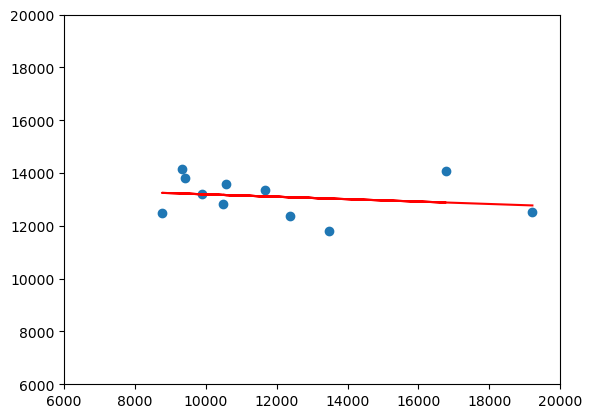

In [27]:
# sample graph for negative R2

mean_cv, r_2, y_pred = testModel('Huber', huber[0], huber[1], 'ABCC3')
x_axis = y_test['ABCC3'].to_list()
pltdf = pd.DataFrame({'x': x_axis, 'y': list(y_pred)})
plt.xlim(6000,20000)
plt.ylim(6000,20000)
plt.scatter(x_axis, y_pred)
m,b = np.polyfit(x_axis, y_pred, 1)
plt.plot(x_axis, m*np.array(x_axis)+b, color='r')
print('R2:', r_2)

In [ ]:
#polynomial kernel does not run on low memory systems

#from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(degree=2, include_bias=False)
# poly_features = poly.fit_transform(data[x_columns])

# X_train, X_test, y_train, y_test = train_test_split(poly_features, data[human_gene], test_size=0.3, random_state=42)

# poly_reg_model = LinearRegression()
# poly_reg_model.fit(X_train, y_train)
# y_pred = poly_reg_model.predict(X_test)
# r_2 = metrics.r2_score(y_test, y_pred)
# print(r_2)